In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
BASE_PATH ='/home/amirh/code/local_explanations_whitebox/tabular/data'
import joblib
from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler, MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
def find_one_hot_vecs(cat_info, all_feat, all_cat_features):
    mapping = {}
    for i in range(len(cat_info)):
        cat_feat_idx = all_cat_features[i]
        val_cat_feat = np.array(cat_info[i]).astype(int)
        
        idx_found = []
        
        for c_f_i in val_cat_feat:
            criteria = np.argwhere('cat__x{}_{}.0'.format(int(cat_feat_idx), int(c_f_i)) == all_feat)[0][0]
            idx_found.append(criteria)
        idx_found = np.array(idx_found)
        mapping[cat_feat_idx] = idx_found

    return mapping

In [7]:
robust_datasets = ['breast_cancer', 'pima_indians', 'banknote', 'iris', 'haberman', 'spambase', 'heart_disease', 'churn', 'hattrick', 'hr', 'audit', 
                                   'loan', 'seismic', 'thera', 'titanic', 'donor', 'adult', 'insurance', 'banking', 'attrition' ]
robust_dataset_names = ['Breast Cancer', 'Pima Indians', 'Banknote', 'Iris', 'Haberman', 'Spambase', 'Heart Disease', 'Churn', 'Hattrick', 'Hr', 'Audit', 
                                   'Loan', 'Seismic', 'Thera', 'Titanic', 'Donor', 'Adult', 'Insurance', 'Banking', 'Attrition' ]
e_names = ['lime', 'shap', 'lpi']
e_names_alt = ['LIME', 'SHAP', 'LPI']

In [339]:
data_key = 'adult'
folder_name = 'exp_v10'
preproc = 'standard'
model = 'lreg'
exp_result = np.load('{}/{}/{}/{}/{}_exp_{}_{}.npy'.format(BASE_PATH, data_key, preproc, folder_name,
                                                                  'shap', 'lreg', preproc), allow_pickle=True)

model_object = joblib.load('{}/{}/{}/{}_v1.joblib'.format(BASE_PATH, data_key, preproc, model))

In [229]:
data_info = pickle.load(open("{}/data_info_v2.p".format(BASE_PATH), "rb"))

In [231]:
all_cat_features = data_info[data_key]['cat_feature_idx']

In [315]:
x_test = np.load('{}/{}/{}/x_test.npy'.format(BASE_PATH, 'adult', 'standard'),  allow_pickle=True)

if len(all_cat_features) > 0: 
    column_transform = ColumnTransformer([("cat", enc, all_cat_features)], remainder='passthrough')

    x_test = column_transform.fit_transform(x_test)
    all_feat = column_transform.get_feature_names_out()
    cat_info = column_transform.transformers_[0][1].categories_
    mapping = find_one_hot_vecs(cat_info, all_feat, all_cat_features)

In [316]:
exp_example = exp_result[0].round(4)
explained_instance = x_test[0]
explained_instance_copy = explained_instance.copy()

In [350]:
mapping

{3: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 1: array([16, 17, 18, 19, 20, 21, 22, 23, 24]),
 5: array([25, 26, 27, 28, 29, 30, 31]),
 6: array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 7: array([47, 48, 49, 50, 51, 52]),
 8: array([53, 54, 55, 56, 57]),
 9: array([58, 59]),
 13: array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100])}

In [317]:
cutoffs = np.linspace(0.05, 0.5, 10)
threshold = int(np.round(cutoffs[3] * exp_example.shape[0]))

In [318]:
type_robust = 'deletion'

In [319]:
feat_selected = np.abs(exp_example).argsort()[::-1][:threshold]
if type_robust == 'insertion':
    #feat_selected = np.abs(exp_example).argsort()[:threshold]
    feat_selected = np.setxor1d(np.arange(exp_example.shape[0]), feat_selected)

In [320]:
for f_sel in feat_selected:
    is_categorical_feat = f_sel in all_cat_features
    if is_categorical_feat:
        all_encoded_f = mapping[f_sel]
        is_enabled_feature = np.argwhere(explained_instance[:, all_encoded_f].toarray().flatten() == 1)[0][0]
        is_enabled_absolute = all_encoded_f[is_enabled_feature]
        get_most_common = np.bincount(x_test[:, is_enabled_absolute].astype(int).toarray().flatten()).argmax()
        explained_instance_copy[:, is_enabled_absolute] = get_most_common 
        
    else:
        explained_instance_copy[:, f_sel] = x_test[:, f_sel].mean()    

In [310]:
explained_instance_copy.toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [312]:
explained_instance.toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [4]:
from sklearn.base import TransformerMixin
import scipy
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if type(X) == scipy.sparse.csr.csr_matrix:    
            return X.todense()
        else: 
            return X

In [484]:
robustness = pickle.load( open( "{}/robustness_measure_v10_latest_final.p".format(BASE_PATH), "rb" ) )


In [353]:
def get_robust(measure_name, model_name):
    res_e = []
    for e in ['lime', 'shap', 'lpi']:
        res = []
        for i in range(20):
            res.append(np.mean(robustness[model_name][e][measure_name][i]))
        res_e.append(res)
    return res_e

In [354]:
base_rri = pd.DataFrame(get_robust('rri', 'lreg'))
base_rri = base_rri.append(pd.DataFrame(get_robust('rri', 'gbayes'))).T
base_rri.columns = ['LIME', 'SHAP', 'LPI', 'LIME', 'SHAP', 'LPI']
base_rri.index = robust_dataset_names

In [355]:
base_rri = base_rri.sort_index()

In [356]:
base_rri.loc['Average'] = base_rri.mean(axis=0)
base_rri.loc['Standard Deviation'] = base_rri.std(axis=0)

In [357]:
base_rri.iloc[:, 3:6].round(2).style.highlight_max(axis=1, color='lightgreen')

,LIME,SHAP,LPI
Adult,0.060000,0.060000,0.050000
Attrition,0.060000,0.070000,0.070000
Audit,1.080000,0.070000,1.340000
Banking,0.040000,0.030000,0.110000
Banknote,0.220000,0.220000,0.220000
Breast Cancer,0.040000,0.040000,0.050000
Churn,0.080000,0.080000,0.090000
Donor,0.430000,0.410000,0.410000
Haberman,0.060000,0.060000,0.060000
Hattrick,0.030000,0.090000,0.070000


In [42]:
print(tabulate(base_rri.round(2), tablefmt="latex_raw"))

\begin{tabular}{lrrrrrr}
\hline
 Adult              & 0.1  & 0.03 & 0.09 & 0.06 & 0.06 & 0.05 \\
 Attrition          & 0.06 & 0.06 & 0.07 & 0.06 & 0.07 & 0.07 \\
 Audit              & 0.12 & 0.04 & 0.22 & 1.08 & 0.07 & 1.34 \\
 Banking            & 0.03 & 0.02 & 0.04 & 0.04 & 0.03 & 0.11 \\
 Banknote           & 0.29 & 0.29 & 0.29 & 0.22 & 0.22 & 0.22 \\
 Breast Cancer      & 0.03 & 0.03 & 0.08 & 0.04 & 0.04 & 0.05 \\
 Churn              & 0.06 & 0.05 & 0.06 & 0.08 & 0.08 & 0.09 \\
 Donor              & 0.34 & 0.39 & 0.37 & 0.43 & 0.41 & 0.41 \\
 Haberman           & 0.07 & 0.07 & 0.07 & 0.06 & 0.06 & 0.06 \\
 Hattrick           & 0.18 & 0.18 & 0.29 & 0.03 & 0.09 & 0.07 \\
 Heart Disease      & 0.13 & 0.09 & 0.16 & 0.21 & 0.1  & 0.29 \\
 Hr                 & 0.01 & 0.01 & 0.01 & 0.01 & 0.01 & 0.01 \\
 Insurance          & 0    & 0    & 0    & 0    & 0.01 & 0.01 \\
 Iris               & 0.25 & 0.25 & 0.25 & 0.27 & 0.27 & 0.27 \\
 Loan               & 0.01 & 0.01 & 0.02 & 0    & 0.02 & 0

In [3]:
robustness = pickle.load( open( "{}/robustness_measure_v11.p".format(BASE_PATH), "rb" ) )

In [4]:
len(robustness['lreg']['lpi']['breast_cancer']['insertion'][0])

10

In [5]:
def process_ax(ax, label_size=14):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = label_size, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_size, weight = 'bold', color = '0.2')

    return ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


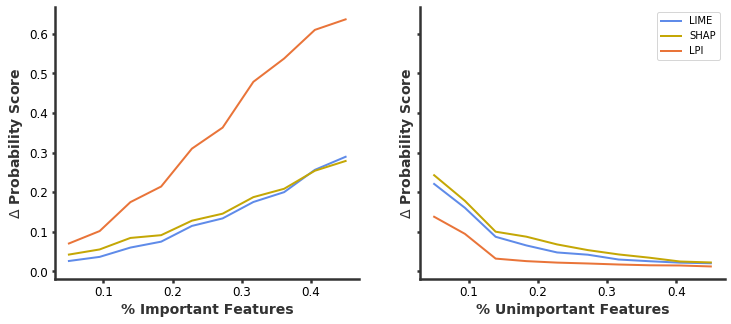

In [8]:
cutoffs = np.linspace(0.05, 0.45, 10)
r_types = ['deletion', 'insertion']
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
d_name = 'breast_cancer'
m_name = 'lreg'
exp_colors = ['#5F8BE9', '#C4A705', '#E97439', '#65ED99']
for i in range(len(r_types)):
    for j in range(len(e_names)):
        _temp_res = np.array(robustness[m_name][e_names[j]][d_name][r_types[i]])
        _avg_res = np.mean(_temp_res, axis = 0)
        ax[i].plot(cutoffs, _avg_res, label=e_names_alt[j], color=exp_colors[j], linewidth=2)
        
        if r_types[i] == 'deletion':
            ax[i].set_xlabel('% Important Features', size=8)
        else: 
            ax[i].set_xlabel('% Unimportant Features', size=10)
        ax[i].set_ylabel(r'$\Delta$ Probability Score', size=10)
        ax[i].tick_params(axis='both', which='major', labelsize=12)
        ax[i] = process_ax(ax[i])
ax[1].legend()
plt.savefig('./robust_{}_{}.eps'.format(d_name, m_name))
plt.show()

In [35]:
cutoffs = np.linspace(0.05, 0.45, 10)
robust_type = 'insertion'

def get_auc(model_name, robust_type):
    auc = {}    
    for i in range(len(robust_datasets)):
        auc[robust_datasets[i]] = {}
        temp_res = []
        data_name = robust_datasets[i]

        for j in range(len(e_names)):   
            auc[robust_datasets[i]][e_names[j]]  = {}
            res_ins = robustness[model_name][e_names[j]][robust_datasets[i]][robust_type]
            temp = np.array(res_ins).mean(axis=1)
            auc_ = 0
            for k in range(1, len(cutoffs) - 1):
                x = cutoffs[k] - cutoffs[k - 1]
                y = temp[k] + temp[k-1]
                auc_ += y / ( 2 * x)
            auc[robust_datasets[i]][e_names[j]] = auc_ 
            
    return auc

In [36]:
auc_insertion_lreg = pd.DataFrame(get_auc('lreg', robust_type))
auc_insertion_gbayes = pd.DataFrame(get_auc('gbayes', robust_type))

In [37]:
insertion = auc_insertion_lreg.append(auc_insertion_gbayes).T.round(2)

In [38]:
insertion.index = robust_dataset_names
insertion = insertion.sort_index()
insertion.loc['Average'] = insertion.mean().round(2)
insertion.loc['Standard Deviation'] = insertion.std().round(2)

In [42]:
insertion.iloc[:,3:6].round(2).style.highlight_min(axis=1)

,lime,shap,lpi
Adult,30.910000,22.120000,27.220000
Attrition,0.000000,0.000000,0.000000
Audit,123.750000,123.750000,123.750000
Banking,6.820000,3.840000,10.290000
Banknote,16.630000,15.800000,18.120000
Breast Cancer,0.000000,0.050000,1.690000
Churn,14.500000,13.430000,21.610000
Donor,0.000000,0.000000,0.000000
Haberman,4.030000,4.690000,4.030000
Hattrick,4.830000,0.770000,15.050000


In [23]:
print(tabulate(insertion, tablefmt="latex_raw"))

\begin{tabular}{lrrrrrr}
\hline
 Adult              & 29.74 & 38.6  & 41.8  &  49.72 &  54.22 &  36.09 \\
 Attrition          & 67.04 & 66.76 & 67.15 &  67.5  &  67.5  &  67.5  \\
 Audit              & 34.63 & 33.4  & 48.94 & 106.88 & 123.75 & 123.75 \\
 Banking            &  9.2  &  9.94 & 11.79 &  27.32 &  28.45 &  20.67 \\
 Banknote           & 72.04 & 72.51 & 77.63 &  25.74 &  26.49 &  28.04 \\
 Breast Cancer      & 23.76 & 13.73 & 73.34 &   4.63 &   7.46 &   4.38 \\
 Churn              & 20.59 & 21.72 & 20.28 &  27.11 &  27.88 &  20.69 \\
 Donor              & 67.27 & 67.29 & 67.28 &  67.5  &  67.5  &  67.5  \\
 Haberman           &  7.6  &  5.71 &  7.54 &   2.97 &   2.29 &   2.97 \\
 Hattrick           & 63.13 & 61.83 & 68.75 &  27.38 &  39.85 &  19.9  \\
 Heart Disease      & 28.53 & 45.18 & 34.19 &  54.61 &  68.31 &  59.57 \\
 Hr                 & 39.41 & 31.51 & 27.84 &  67.5  &  67.5  &  67.5  \\
 Insurance          &  1.22 &  1.54 &  0.96 &   0    &   0    &   0    \\
 Iris 